# Time Series Tutorial

## Time series info:

Time series are an important visualization to see the trends of whatever variable you are intereted in seeing over time. In this notebook, we will be covering how to create a time series for the persent day model and the future projected model. This notebook will be the basis of how to create a simple time series using the package `matplotlib`.

### CESM1 Large Ensemble
This portion of the notebook will detail how to get access to the CESM1 large Ensemble dataset, which is hosted on Amazon Web Services. Since it is hosted on Amazon Web services, the users accessing this data will not have to create a separate account. More information on the details of this dataset can be found [here](https://ncar.github.io/cesm-lens-aws/) which is also briefly discussed below. Directions will be followed very similarly to a NCAR repository labeled [CESM LENS on AWS](https://github.com/NCAR/cesm-lens-aws).

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files.

Things to note about the data we are accessing:

- The notebook will be accessing the Ocean model for CESM1
- Because of this the grid file used here is only for OCEAN variables; the atmosphere and land variables have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".
- This notebook will only be looking at a few variables as an example. If you are inclined to view other variables, a whole list can be found [here](https://www.cesm.ucar.edu/community-projects/lens/data-sets)


To first open connection to where the files are housed, we need to open the connection by using the `intake` function

### Data Access
This notebook uses information from a notebook from the NCAR organization that can be found [here](https://ncar.github.io/CESM-Tutorial/notebooks/diagnostics/clm_ctsm/basics_clm.html#first-calculate-the-land-weights). To properly ensure you have the correct packages installed to correctly access the data, make sure to view the .README for this repository found [here](https://github.com/Channelislanders/toolkit).

Here we are:
- Accessing the OCN model dataset with RCP 8.5 and 20C runs. RCP 8.5 runs are the 'worst case scenario' runs, looking at years from 2000 to 2100. 20C runs are present day runs, looking at years from 1920 to 2000
- Narrowing down the columns to specific variables we aim to access. In this case, example variables can be dissolved oxygen, salinity, nutrients, and temperature (sea surface or below)

For example:
```
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)
```
In this example, we are looking for monthly data, with the component 'ocn', finding the variable 'TEMP' and locating the two experiments, 20C and RCP85.



This section works similar to accessing other catalogs. In this notebook, we will be using Zarr. More information on the library below.
https://zarr.readthedocs.io/en/stable/

#### Importing Packages
In order to access the data, we'll need to import all necessary packages to do so. Below are the packages I have installed to use throughout this notebook:

In [2]:
#import packages
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

In [45]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
# open the catalog using the intake function
col = intake.open_esm_datastore(cat_url)
#view the catalog
col

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


By calling the .search() method on the collection object, we can search for specific datasets that match our criteria. For example, we can search and modigy the search to find the variables associated with the 'ocn' model. A list of variables can be found [here](https://www.cesm.ucar.edu/community-projects/lens2/output-variables)

In [46]:
# Search for all possible variables for OCN component 
col.search(component="ocn").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,DIC,dissolved inorganic carbon,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-DIC...
1,DOC,dissolved organic carbon,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-DOC...
2,FW,freshwater flux,ocn,20C,monthly,1.0,global_ocean,centimeter/s,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-FW....
3,HMXL,mixed-layer depth,ocn,20C,monthly,1.0,global_ocean,centimeter,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-HMX...
4,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
...,...,...,...,...,...,...,...,...,...,...,...
123,WVEL,vertical velocity,ocn,RCP85,monthly,60.0,global_ocean,centimeter/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-W...
124,NaN,NaN,ocn,CTRL,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
125,NaN,NaN,ocn,HIST,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
126,NaN,NaN,ocn,RCP85,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr


Now we want to get a more detailed look at the dataset. To subset correctly, we will use the dictionary framework to call for variables we are interested in looking at.

In [47]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 scenarios
variables = ["TEMP", "SALT", "O2"]
col_ocn = {}

for var in variables:
    col_ocn[f"{var}"] = col.search(
        frequency=["monthly"],
        component="ocn",
        variable=var,
        experiment=["20C", "RCP85"],
    )

print(col_ocn)

#Display the first few entries in the resulting data frame
col_ocn["TEMP"].df
col_ocn["SALT"].df
col_ocn["O2"].df

{'TEMP': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'SALT': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'O2': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>}


,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...


The reasoning behind creating a for loop to iterate over the variables is because loading in the full data gives a warning that the size of the data is too large. By loading in the data in chunks, we can avoid this warning.

For this particular notebook, we are interesting in monthly data spanning from 1920 to 2100. Historical data is from 1920 to 2005 and RCP 8.5 is from 2006 to 2100. Our variables of interest were pre-determined by the Channel Islands Sanctuary staff, so we are only interested in the following variables:

- SST (Sea Surface Temperature)
- O2 (Dissolved Oxygen)
- SALT (Salinity)

In [48]:
# Load catalog entries for subset into a dictionary of xarray datasets
#Lets create another for loop to iteratre over the col_ocn dictionary

dsets = {}
for var in variables:
    dsets[var] = col_ocn[var].to_dataset_dict(
        zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
    )
    print(f"\nDataset dictionary keys for {var}:\n {dsets[var].keys()}")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for TEMP:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for SALT:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for O2:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


And that is how we load in the data! Certain aspects such as the variable and experiment of interest are able to be changed to the discretion of the user. This gives the user the most flexibility to look at variables that they are most interested in.

### Data Wrangling

This section will cover some ways we recommend you wrangling the data to make the `xarray` easier to work with. The code chunk above loads in the catalog entries into a dictionary of xarray datasets. The dictionary is then used to load the data into a single xarray dataset.

Now let's assign a variable to each of the datasets we are interested in. 

In [49]:
# Define Xarray datasets corresponding to the two experiments by each variable 
ds_20C_TEMP = dsets["TEMP"]["ocn.20C.monthly"]
ds_RCP85_TEMP = dsets["TEMP"]["ocn.RCP85.monthly"]

ds_20C_SALT = dsets["SALT"]["ocn.20C.monthly"]
ds_RCP85_SALT = dsets["SALT"]["ocn.RCP85.monthly"]

ds_20C_O2 = dsets["O2"]["ocn.20C.monthly"]
ds_RCP85_O2 = dsets["O2"]["ocn.RCP85.monthly"]

Since this is a time series, we are interested in looking at the overall change from 1920 to 2100. To do this, we need to merge the 20C dataset and the RCP 8.5 dataset. We will use the `xr.concat` function from xarray, merging the two datasets by the dimension `time`.

In this example and all other examples found in this notebook, I will be focusing on the `TEMP` variable. Above are the code syntax to use if you would like to use other variables to look at.

In [50]:
#merge the two dataset together
merge_temp = xr.concat([ds_20C_TEMP, ds_RCP85_TEMP], dim ='time')
merge_temp

<xarray.Dataset> Size: 3TB
Dimensions:     (member_id: 40, time: 2172, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time        (time) object 17kB 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bound  (time, d2) object 35kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 3TB dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

In [51]:
#take the mean of the member_id so it will not show up as a dimension
#look at one member_id
ds_20C_1=merge_temp.sel(member_id = 1)
ds_20C_1

<xarray.Dataset> Size: 64GB
Dimensions:     (time: 2172, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
    member_id   int64 8B 1
  * time        (time) object 17kB 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bound  (time, d2) object 35kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 64GB dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

#### Slicing for a specific time frame

As this notebook is concerned with the time between 1950 to 2000, we will be slicing our xarray to feature that time frame using the function `.sel`.

In [52]:
ds_20C_1.sel(time=slice("1950", "2000"))

<xarray.Dataset> Size: 18GB
Dimensions:     (time: 612, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
    member_id   int64 8B 1
  * time        (time) object 5kB 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
    time_bound  (time, d2) object 10kB dask.array<chunksize=(612, 2), meta=np.ndarray>
  * z_t         (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 18GB dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

At the moment, we are looking at all of the information found in the `xarray`. Let's break it down to a smaller portion to make it easier to deal with. I'll be looking at a specific z_t portion of the `xarray` as well as narrowing down the time variable to have an `xarray` that is easy to work with.

In [53]:
#select for just one z_t to look at
temp_zt_0 = ds_20C_1.TEMP.sel(z_t = 0, method = "nearest")
#select for just the time containing the year 2000
temp_2000 = temp_zt_0.sel(time='2000')
#print the xarray
temp_2000

<xarray.DataArray 'TEMP' (time: 12, nlat: 384, nlon: 320)> Size: 6MB
dask.array<getitem, shape=(12, 384, 320), dtype=float32, chunksize=(6, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    member_id  int64 8B 1
  * time       (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B 500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

### Data Exploring

This section will cover some data exploration and what are in these xarrays. It is recommended to have a good foundation on what xarrays are and how to understand them. Here is a link that details what xarrays are and how you can manipulate [them](https://earth-env-data-science.github.io/lectures/xarray/xarray_intro.html).

Let's go ahead and load in our dataset from the previous code chunk:

In [54]:
#print the edited xarray
temp_2000

<xarray.DataArray 'TEMP' (time: 12, nlat: 384, nlon: 320)> Size: 6MB
dask.array<getitem, shape=(12, 384, 320), dtype=float32, chunksize=(6, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    member_id  int64 8B 1
  * time       (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B 500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

Here, we have 4 different types of attributes found in this xarray: `Dimensions`, `Coordinates`, `Indexes`, and `Attributes`. `xarrays` usually have a `Data Variable column`, but because we have already included that in our code indicating that is the variable we want to take a look at, it is not included in the information.

Looking at this `xarray`, we know that the `time` dimension contains 12 observations, the `nlat` contains 384 observations, and the `nlon` contains 320 observations. For this notebook, it's important that you pinpoint one particular point on the map in order to correctly render the time series correctly (eg. `isel(nlat = 35, nlot = 60`). Skipping this step will not render the line plot correctly.

## Plotting the time series

Now, we will go ahead and plot the time series. A time series is useful in many scenarios as it can show trends in the data. Multiple statistical methods can be done on this type of series, including different types of regressions. You can read more about this [here](https://doi.org/10.1016/j.earscirev.2018.12.005).

In this section, we will go over how to make a simple time series. This time series will not have any other type of statistical analysis but if you are looking for particular trends with the help of other statistical tools, I recommend looking online to see how this can be achieved. *maybe ask teammate if this section of the notebook is necessary*


### Example code of how to create the time series

Below is an example code of how I created the time series. Parts of this code are very interchangeable with it being:
- `time`
- `z_t`
- `member_id`
- `nlat`
- `nlon`

**A couple of important notes**: 

- This takes a long time to load! We believe it is because of where the data is stored on the AWS server. Once you have the data subsetted to the area you are interested in, we recommend downloading that file as an .nc file. This will take a long time to load but this will allow you to look into that subsetted area much faster.

- When creating a timeseries, it is important to indicate one point when selecting the `nlat` and `nlon` coordinates. If you create a slice to cover a whole area, the plot will create a histogram, counting up the number of times a particular temperature has been recorded for that area. In this example, we have pinpointed `nlat` and `nlon` that is closest to the Channel Island area.

- The time format is in `cftime.DatetimeNoLeap`. Because it is not in a `Datetime` format, an additional package will need to be installed. I recommend running `pip install nc-time-axis` in your terminal to properly install that package.


*I added a code chunk that is commented out that allows you to download and and read in the `.nc` files. It is commented out but feel free to uncomment it out if you choose to download your files as an `.nc` file.*


In [55]:
# how to download .nc files, .to_netcdf() is the function to download the files

#"FILE_NAME" = FILE_YOU_HAVE_NAMED.to_netcdf('GIVE_A_NAME_FOR_.nc_FILES')

In [56]:
#example code

#select just one point on the graph (this point is closest to channel islands)
test_2 = merge_temp.isel(nlat=(280), nlon=(240))

#slice for particular timeframe
test_2000 = test_2.sel(time=slice("1920", "2000"))

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
point_2 = test_2000.TEMP.sel(z_t = 0, method = "nearest")

#select a member_id
point_3 = point_2.sel(member_id = 1)
point_3

<xarray.DataArray 'TEMP' (time: 972)> Size: 4kB
dask.array<getitem, shape=(972,), dtype=float32, chunksize=(6,), chunktype=numpy.ndarray>
Coordinates:
    member_id  int64 8B 1
  * time       (time) object 8kB 1920-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B 500.0
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

Text(0.5, 1.0, 'Sea Surface temperature Time Series')

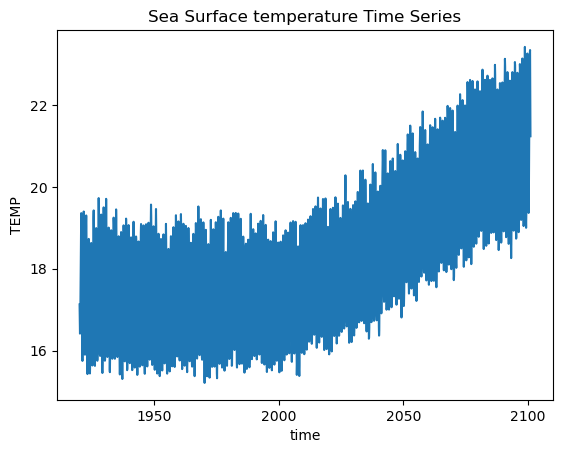

In [4]:
#for running this plot fast, I have added this code chunk to read in an .nc file related to this notebook
#note that this .nc is configured to this notebook only. I do not recommend using this .nc file for other uses.

temp_file = xr.open_dataset("data/time_series/20C_rcp85_temp.nc")

#plot out time series graph
temp_file.TEMP.sel(z_t = 0, method = "nearest").mean("member_id").plot()

#add title to graph
plt.title("Sea Surface temperature Time Series")

C:\Users\patty\AppData\Local\Temp\ipykernel_20956\3721157379.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time = mean_id.indexes['time'].to_datetimeindex()


Text(0.5, 1.0, 'Mean Sea Surface Tempurature Time Series')

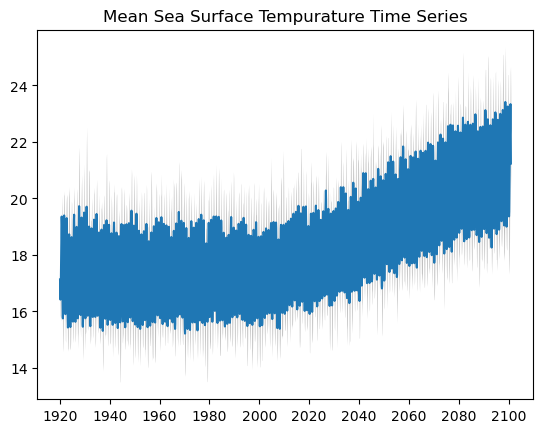

In [64]:
# To find the max and min of the time series.
point_2 = temp_file.TEMP.sel(z_t = 0, method = "nearest")

#find the mean, max and min of the member_id
mean_id = point_2.mean("member_id")
max_id = point_2.max("member_id")
min_id = point_2.min("member_id")

#convert the time for the mean_id from cftime to datetime
time = mean_id.indexes['time'].to_datetimeindex()

# plot
fig, ax = plt.subplots()

ax.plot(time, mean_id)
ax.fill_between(time, min_id, max_id, alpha=.5, linewidth=0, color = 'gray')

plt.title("Mean Sea Surface Tempurature Time Series")


And there you have it! You have sucessfully created a time series graph for the Channel Islands. If you feel you want to customize the graph even more than the basic layout here, check out the xarray link [here](https://docs.xarray.dev/en/stable/user-guide/plotting.html).